# TLS Experiments of UA Q2

In [22]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q2
TLS_index = 1 # for TLS of interest
dc_flux_index = 1 # for dc line

In [23]:
Analysis = AnalysisHandle("quam_state_q1.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [ ]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
Experiment.set_octave.set_clock(machine)

In [3]:
# set for the qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q1 for (LO, IF) = (6.251 GHz, -50.000 MHz)
------------------------------------- Calibrates r1 for (LO, IF) = (7.183 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# TLS Characterizations

In [ ]:
TLS_index = 1

## TLS T1 (swap)

In [4]:
%matplotlib qt
tau_sweep_abs = np.arange(20,3000E3+1,100E3)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1(machine, tau_sweep_abs, qubit_index, TLS_index,
                   n_avg = 500, cd_time_qubit = 25E3, cd_time_TLS = 1000E3, live_plot = True, data_process_method = 'I')

Execution stopped by user!############                       ] 54.0% (n=270/500) --> elapsed time: 19.95s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_T1_swap) --> elapsed time: 20.57s


Qubit T1: 345.4 [us]


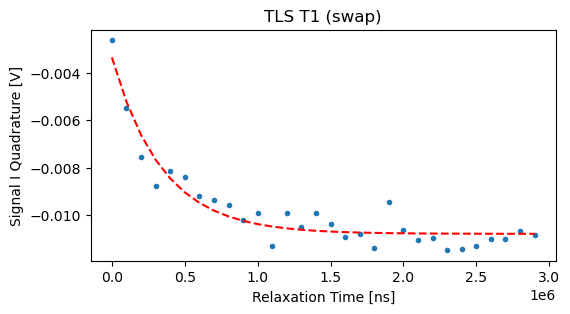

In [6]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Driving Pulses

## set rf_gain for TLS pulse

In [7]:
machine.octaves[0].LO_sources[1].gain = 10

## TLS spectroscopy

In [8]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-15E6,15E6+1,0.3E6)
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_freq(machine, TLS_freq_sweep, qubit_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, live_plot = True)

TLS if range > 400MHz. Setting the octave freq. Will calibrate octave.
------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q1 for (LO, IF) = (5.353 GHz,  50.000 MHz)
------------------------------------- Octave calibration finished.
Execution stopped by user!                                   ] 15.7% (n=157/1000.0) --> elapsed time: 8.17s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_spec1000.0) --> elapsed time: 8.45s


peak frequency:  5403.0 [MHz]


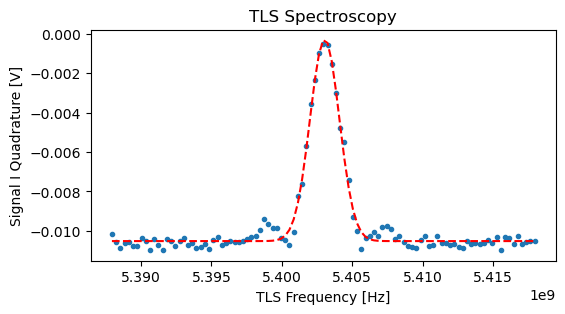

In [5]:
%matplotlib inline
TLS_freq = Analysis.exp1D.peak_fit(expt_dataset, method = "Gaussian", data_process_method = 'I')
machine.qubits[qubit_index].f_tls[TLS_index] = TLS_freq + 0E6
machine = Analysis.set_machine(machine)

## TLS rabi

change rf gain of octave

In [12]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 300 + 0.1, 4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_rabi_length(machine, rabi_duration_sweep, qubit_index, TLS_index,
                      n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Execution stopped by user!                                   ] 5.0% (n=50/1000.0) --> elapsed time: 5.29s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_time_rabi_2-> elapsed time: 5.50s


rabi_pi_pulse: 112.8 [ns]
pi period: 109.49 [ns]
T2rabi: 2103.2 [ns]


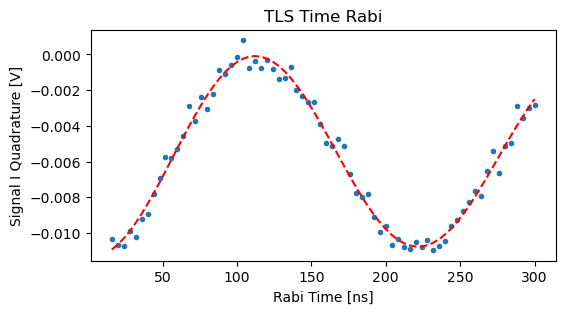

In [22]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Decay", to_plot = True, data_process_method = 'I')

In [10]:
0.47981 * 112.8 / 112

0.4832372142857143

In [11]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index] = 0.483237
machine.qubits[qubit_index].pi_length_tls[TLS_index] = 112
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [13]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 1800 + 0.1, 28)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.TLS_ramsey(machine, ramsey_duration_sweep, qubit_index, TLS_index,
                       n_avg = 1000, detuning = 5E6, cd_time_qubit = 25E3, cd_time_TLS = 500E3, live_plot = True)

Execution stopped by user!                                   ] 25.0% (n=250/1000) --> elapsed time: 8.25s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_ramsey00) --> elapsed time: 8.52s


Qubit T2*:  583.6 [ns]
Exponent n =  0.6
Detuning =  4.8 [MHz]


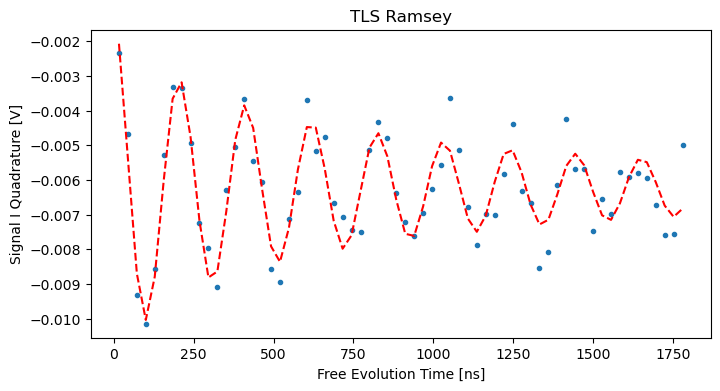

In [14]:
%matplotlib inline
tls_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')

As a sanity check, run fft, see if there are multiple peaks

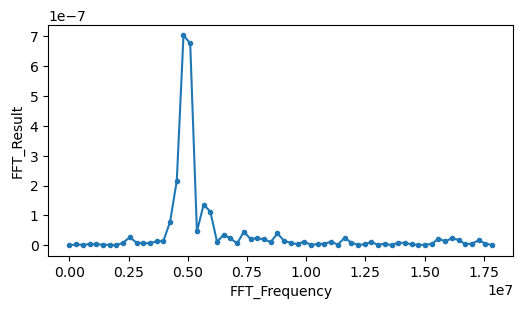

In [15]:
fft_dataset = Analysis.exp1D.fft(expt_dataset, data_process_method = 'I')

## TLS T1 with direct driving

In [16]:
%matplotlib qt
tau_sweep_abs = np.arange(1E3,2500E3+1,100E3)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1_drive(machine, tau_sweep_abs, qubit_index, TLS_index,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 2000E3, live_plot = True)

Execution stopped by user!                                   ] 7.0% (n=70/1000.0) --> elapsed time: 5.33s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_T1_drive) --> elapsed time: 5.91s


Qubit T1: 477.1 [us]


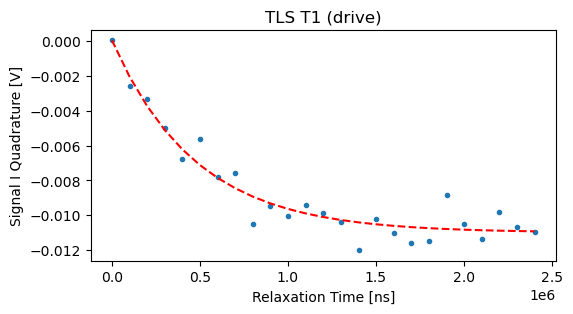

In [18]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Dynamical Decoupling

## Longer Timescale Decay

### echo

In [24]:
%matplotlib qt
tau_sweep_abs = np.arange(500, 120E3 + 0.1, 2E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_echo(machine, tau_sweep_abs, qubit_index, TLS_index, n_avg = 1E3,
                     cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Execution stopped by user!                                   ] 5.0% (n=50/1000.0) --> elapsed time: 4.71s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_echo_2.0) --> elapsed time: 5.26s


Qubit T2*:  46.9 [us]
Exponent n =  6.0


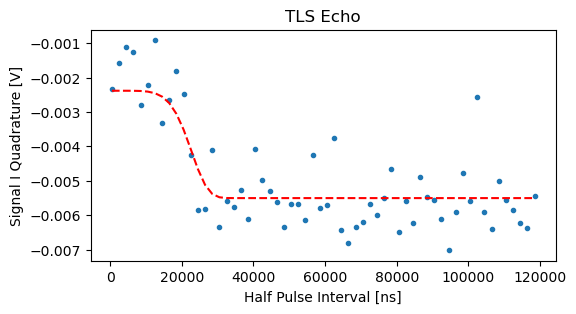

In [21]:
%matplotlib inline
TLS_T2echo = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau =2)

### CPMG-2

In [ ]:
%matplotlib qt
N_CPMG = 2
tau_sweep_abs = np.arange(500, 80E3 + 0.1, 2E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

In [ ]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

### CPMG-8

In [23]:
%matplotlib qt
N_CPMG = 8
tau_sweep_abs = np.arange(500, 30E3 + 0.1, 1.5E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 35.46s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 35.50s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg8_5
Execution stopped by user!


Qubit T2*:  121.0 [us]
Exponent n =  2.3


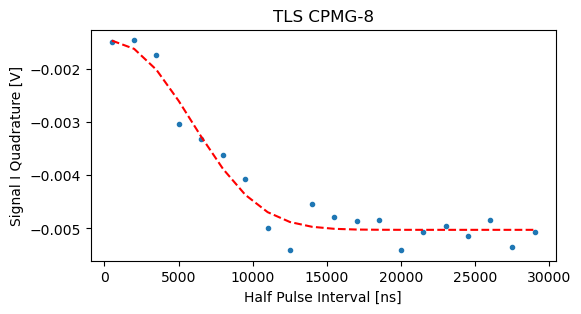

In [25]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

## Shorter Timescale Dynamics

### CPMG-4

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3094.52s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3094.58s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3094.62s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3094.66s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg4_3


<Figure size 800x400 with 0 Axes>

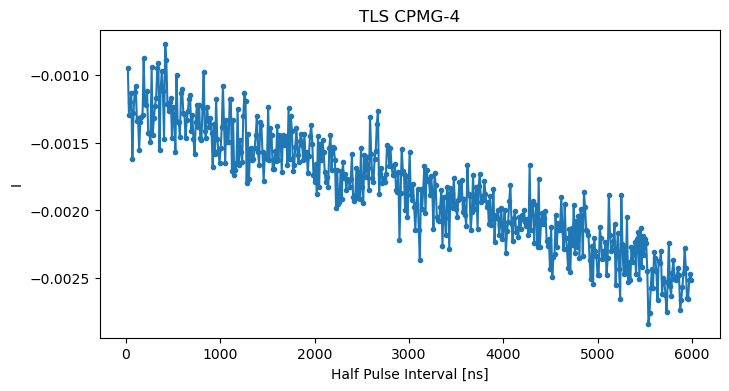

In [29]:
%matplotlib inline
N_CPMG = 4
tau_sweep_abs = np.arange(20, 6E3 + 0.1, 12)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = False)

In [ ]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg4.nc")
expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
plt.title(expt_dataset.attrs['long_name'])

### CPMG-8

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3143.26s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3143.31s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3143.35s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3143.38s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg8_7


<Figure size 800x400 with 0 Axes>

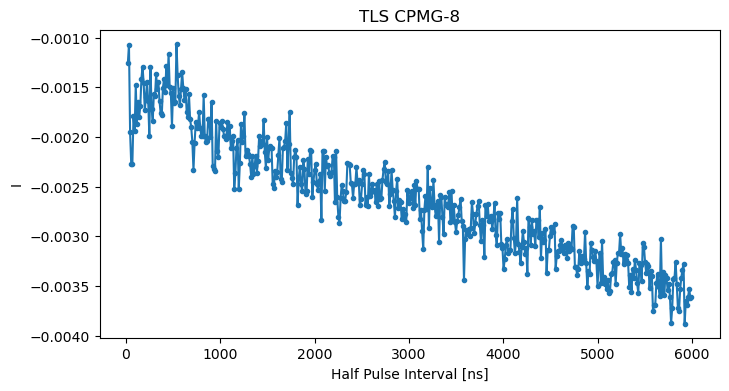

In [30]:
%matplotlib inline
N_CPMG = 8
tau_sweep_abs = np.arange(20, 2E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = False)

In [ ]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg8_4.nc")
expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
plt.title(expt_dataset.attrs['long_name'])

### CPMG-16

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3241.12s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3241.18s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3241.22s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3241.26s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_cpmg16


<Figure size 800x400 with 0 Axes>

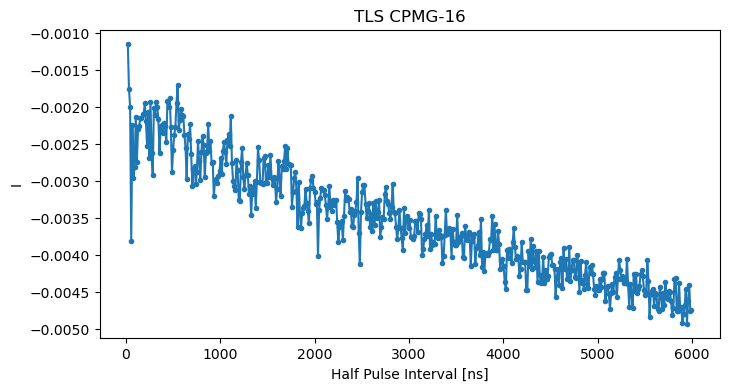

In [31]:
%matplotlib inline
N_CPMG = 16
tau_sweep_abs = np.arange(20, 2E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = False)

In [ ]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg16.nc")
expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
plt.title(expt_dataset.attrs['long_name'])

### CPMG-32

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3436.75s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3436.79s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3436.83s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3436.86s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_cpmg32


<Figure size 800x400 with 0 Axes>

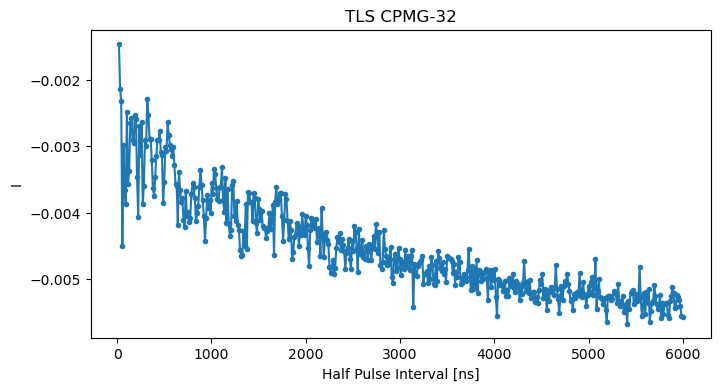

In [32]:
%matplotlib inline
N_CPMG = 32
tau_sweep_abs = np.arange(20, 2E3 + 0.1, 12)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = False)

### CPMG-40

In [38]:
%matplotlib qt
N_CPMG = 40
tau_sweep_abs = np.arange(16, 1.2E3 + 0.1, 4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 2E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 937.50s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 937.53s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_cpmg40
Execution stopped by user!
